# Testing the signal quality with Alphalens

## Imports & Settings

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

from pathlib import Path
import pandas as pd
import seaborn as sns

from alphalens.tears import (create_summary_tear_sheet,
                             create_full_tear_sheet, 
                             create_returns_tear_sheet)

from alphalens.utils import get_clean_factor_and_forward_returns
from alphalens import utils

In [3]:
sns.set_style('whitegrid')

In [4]:
idx = pd.IndexSlice

In [5]:
results_path = Path('results', 'return_predictions')
if not results_path.exists():
    results_path.mkdir(parents=True)

## Evaluating the Cross-Validation Results

In [6]:
lookahead = 1

In [7]:
cv_store = Path(results_path / 'parameter_tuning.h5')

### Get AlphaLens Input

In [8]:
DATA_DIR = Path('..', 'data')

Using next available prices.

In [81]:
def get_trade_prices(tickers):
    store = DATA_DIR / 'assets.h5'
    prices = pd.read_hdf(store, 'finance_datareader/prices')
    return (prices.loc[idx['2010': '2019', tickers], 'adj_open']
            .unstack('ticker')
            .rename(columns=lambda x: x.replace('adj_', ''))
            .fillna(method='bfill')
            .fillna(0)
            .shift(-1)
            .dropna()
            .tz_localize('UTC')
           )
           

Reloading predictions.

In [10]:
best_predictions = pd.read_hdf(results_path / 'predictions.h5', f'test/{lookahead:02}')
best_predictions.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 197500 entries, ('000020', Timestamp('2019-12-20 00:00:00')) to ('114090', Timestamp('2017-12-19 00:00:00'))
Data columns (total 11 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   y_test  197500 non-null  float64
 1   0       197500 non-null  float64
 2   1       197500 non-null  float64
 3   2       197500 non-null  float64
 4   3       197500 non-null  float64
 5   4       197500 non-null  float64
 6   5       197500 non-null  float64
 7   6       197500 non-null  float64
 8   7       197500 non-null  float64
 9   8       197500 non-null  float64
 10  9       197500 non-null  float64
dtypes: float64(11)
memory usage: 17.4+ MB


In [11]:
test_tickers = best_predictions.index.get_level_values('ticker').unique()

In [12]:
trade_prices = get_trade_prices(test_tickers)
trade_prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2466 entries, 2010-01-04 00:00:00+00:00 to 2019-12-30 00:00:00+00:00
Columns: 395 entries, 000020 to 114090
dtypes: float64(395)
memory usage: 7.5 MB


In [13]:
factor = (best_predictions
          .iloc[:, :3]
          .mean(1)
          .tz_localize('UTC', level='date')
          .swaplevel()
          .reset_index()
          .drop_duplicates()
          .set_index(['date', 'ticker'])
          .dropna()
          .sort_index()
         )

## 주가가 0이된 기업 제외

In [15]:
desc = trade_prices.describe().min()
exclude_index = desc[desc == 0].index

In [16]:
factor

0
date                      ticker          
2017-12-13 00:00:00+00:00 000020  0.000988
                          000100  0.005336
                          000120 -0.003227
                          000140 -0.001241
                          000210 -0.001231
...                                    ...
2019-12-27 00:00:00+00:00 105560 -0.002481
                          105630 -0.000099
                          108670 -0.000085
                          111770  0.002788
                          114090  0.004567

[197500 rows x 1 columns]

In [17]:
filter_index = factor.index.get_level_values('ticker').unique().difference(exclude_index)

In [18]:
factor = factor.loc[idx[:, filter_index], :]

In [19]:
trade_prices = trade_prices.reindex(columns=filter_index)

## Factor Data 계산

In [20]:
factor_data = get_clean_factor_and_forward_returns(factor=factor,
                                                   prices=trade_prices,
                                                   quantiles=5,
                                                   periods=(1, 5, 10, 21))
factor_data.sort_index().info()

Dropped 4.0% entries from factor data: 4.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 186240 entries, (Timestamp('2017-12-13 00:00:00+0000', tz='UTC', freq='C'), '000020') to (Timestamp('2019-11-28 00:00:00+0000', tz='UTC', freq='C'), '114090')
Data columns (total 5 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   5D               186240 non-null  float64
 1   10D              186240 non-null  float64
 2   21D              186240 non-null  float64
 3   factor           186240 non-null  float64
 4   factor_quantile  186240 non-null  int64  
dtypes: float64(4), int64(1)
memory usage: 7.9+ MB


In [21]:
factor_data.loc[idx['2018-03-28',:], :]

5D       10D       21D    factor  \
date                      asset                                            
2018-03-28 00:00:00+00:00 000020  0.064103  0.132479  0.012821  0.010030   
                          000100  0.072256  0.207468  0.095576  0.011116   
                          000120  0.049618  0.038168  0.179389  0.020452   
                          000140  0.017653  0.012461 -0.014538  0.000551   
                          000210 -0.014742  0.032170  0.159514 -0.004506   
...                                    ...       ...       ...       ...   
                          105560 -0.041254 -0.031353 -0.009901  0.010274   
                          105630  0.011601  0.002320  0.044084 -0.002822   
                          108670 -0.006410  0.034615 -0.010256 -0.001489   
                          111770  0.001838 -0.007353  0.139706  0.001092   
                          114090  0.088843  0.012397  0.095041  0.006529   

                                  factor_quantile  
date                      asset                    
2018-03-28 00:00:00+00:00 000020                5  
                          000100                5  
                          000120                5  
                          000140                2  
                          000210                1  
...                                           ...  
                          105560                5  
                          105630                1  
                          108670                2  
                          111770                2  
                          114090                4  

[388 rows x 5 columns]

### Summary Tearsheet

Returns Analysis


,5D,10D,21D
Ann. alpha,3.094,1.003,0.394
beta,0.016,0.017,0.021
Mean Period Wise Return Top Quantile (bps),237.074,114.125,54.125
Mean Period Wise Return Bottom Quantile (bps),-209.689,-106.689,-51.614
Mean Period Wise Spread (bps),446.762,220.813,105.712


<Figure size 432x288 with 0 Axes>

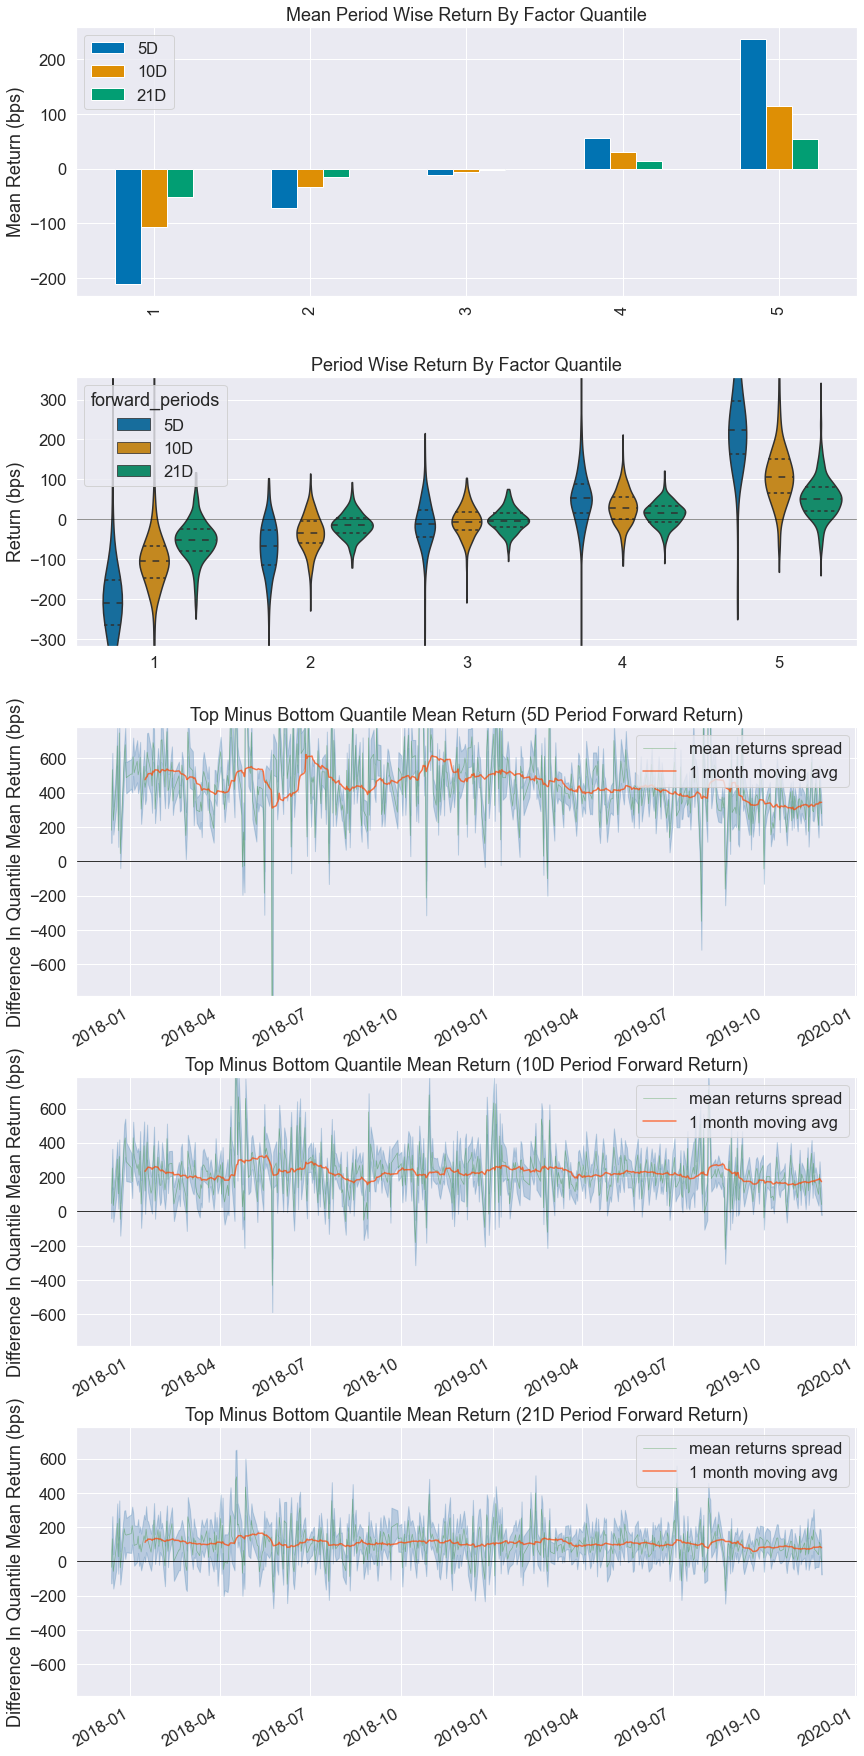

In [22]:
create_returns_tear_sheet(factor_data)

Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1,-0.101569,0.005558,-0.008754,0.007263,37440,20.103093
2,-0.028738,0.009943,-0.002841,0.003733,36960,19.845361
3,-0.020183,0.014394,-0.000259,0.003264,37442,20.104167
4,-0.015556,0.021753,0.002418,0.003421,36958,19.844287
5,-0.010506,0.106752,0.010335,0.010561,37440,20.103093


Returns Analysis


,5D,10D,21D
Ann. alpha,3.094,1.003,0.394
beta,0.016,0.017,0.021
Mean Period Wise Return Top Quantile (bps),237.074,114.125,54.125
Mean Period Wise Return Bottom Quantile (bps),-209.689,-106.689,-51.614
Mean Period Wise Spread (bps),446.762,220.813,105.712


Information Analysis


,5D,10D,21D
IC Mean,0.335,0.242,0.170
IC Std.,0.115,0.122,0.122
Risk-Adjusted IC,2.921,1.989,1.393
t-stat(IC),64.000,43.579,30.527
p-value(IC),0.000,0.000,0.000
IC Skew,-0.750,-0.339,-0.064
IC Kurtosis,2.403,0.560,0.904


Turnover Analysis


,5D,10D,21D
Quantile 1 Mean Turnover,0.782,0.778,0.778
Quantile 2 Mean Turnover,0.789,0.794,0.796
Quantile 3 Mean Turnover,0.777,0.776,0.778
Quantile 4 Mean Turnover,0.793,0.791,0.797
Quantile 5 Mean Turnover,0.781,0.778,0.783


,5D,10D,21D
Mean Factor Rank Autocorrelation,-0.02,-0.005,-0.009


<Figure size 432x288 with 0 Axes>

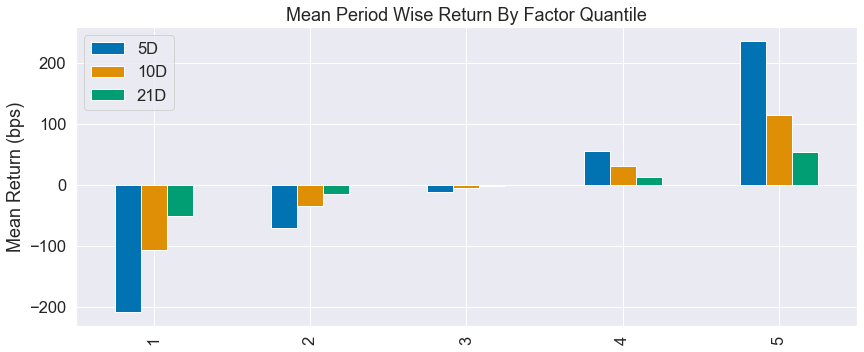

In [23]:
create_summary_tear_sheet(factor_data)

## Evaluating the Out-of-sample predictions

### Prepare Factor Data

In [82]:
t = 1
predictions = pd.read_hdf(results_path / 'predictions.h5',
                          f'test/{t:02}').drop('y_test', axis=1)

In [83]:
predictions.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 197500 entries, ('000020', Timestamp('2019-12-20 00:00:00')) to ('114090', Timestamp('2017-12-19 00:00:00'))
Data columns (total 10 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   0       197500 non-null  float64
 1   1       197500 non-null  float64
 2   2       197500 non-null  float64
 3   3       197500 non-null  float64
 4   4       197500 non-null  float64
 5   5       197500 non-null  float64
 6   6       197500 non-null  float64
 7   7       197500 non-null  float64
 8   8       197500 non-null  float64
 9   9       197500 non-null  float64
dtypes: float64(10)
memory usage: 15.9+ MB


In [84]:
factor = (predictions.iloc[:, :10]
                   .mean(1)
                   .sort_index().tz_localize('UTC', level='date').swaplevel().dropna())
factor.head()

date                       ticker
2017-12-13 00:00:00+00:00  000020    0.000480
2017-12-14 00:00:00+00:00  000020   -0.000332
2017-12-15 00:00:00+00:00  000020   -0.000693
2017-12-18 00:00:00+00:00  000020    0.001308
2017-12-19 00:00:00+00:00  000020    0.001681
dtype: float64

### Select next available trade prices

Using next available prices.

In [85]:
tickers = factor.index.get_level_values('ticker').unique()
trade_prices = get_trade_prices(tickers)
trade_prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2465 entries, 2010-01-04 00:00:00+00:00 to 2019-12-27 00:00:00+00:00
Columns: 395 entries, 000020 to 114090
dtypes: float64(395)
memory usage: 7.4 MB


## 주가가 0인 데이터 삭제

In [86]:
desc = trade_prices.describe().min()
exclude_index = desc[desc == 0].index

In [87]:
filter_index = factor.index.get_level_values('ticker').unique().difference(exclude_index)

In [88]:
factor = factor.to_frame().loc[idx[:, filter_index], :]

In [89]:
trade_prices = trade_prices.reindex(columns=filter_index)

### Get AlphaLens Inputs

In [90]:
factor_data = get_clean_factor_and_forward_returns(factor=factor,
                                                   prices=trade_prices,
                                                   quantiles=5,
#                                                    periods=(1, 5, 10, 21)
                                                   periods=(1,)
                                                  )
factor_data.sort_index().info()

Dropped 0.2% entries from factor data: 0.2% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 193113 entries, (Timestamp('2017-12-13 00:00:00+0000', tz='UTC', freq='C'), '000020') to (Timestamp('2019-12-26 00:00:00+0000', tz='UTC', freq='C'), '114090')
Data columns (total 3 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   1D               193113 non-null  float64
 1   factor           193113 non-null  float64
 2   factor_quantile  193113 non-null  int64  
dtypes: float64(2), int64(1)
memory usage: 5.2+ MB


### Summary Tearsheet

Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1,-0.017300,0.006888,-0.000653,0.002538,38924,20.156074
2,-0.015194,0.007050,-0.000157,0.002226,38424,19.897159
3,-0.014934,0.007351,0.000065,0.002164,38423,19.896641
4,-0.014713,0.008691,0.000458,0.002242,38422,19.896123
5,-0.014493,0.014229,0.001701,0.002901,38920,20.154003


Returns Analysis


,1D
Ann. alpha,0.439
beta,0.139
Mean Period Wise Return Top Quantile (bps),12.212
Mean Period Wise Return Bottom Quantile (bps),-16.897
Mean Period Wise Spread (bps),29.109


Information Analysis


,1D
IC Mean,0.040
IC Std.,0.131
Risk-Adjusted IC,0.308
t-stat(IC),6.875
p-value(IC),0.000
IC Skew,0.114
IC Kurtosis,0.368


Turnover Analysis


,1D
Quantile 1 Mean Turnover,0.631
Quantile 2 Mean Turnover,0.719
Quantile 3 Mean Turnover,0.738
Quantile 4 Mean Turnover,0.751
Quantile 5 Mean Turnover,0.621


,1D
Mean Factor Rank Autocorrelation,0.252


<Figure size 432x288 with 0 Axes>

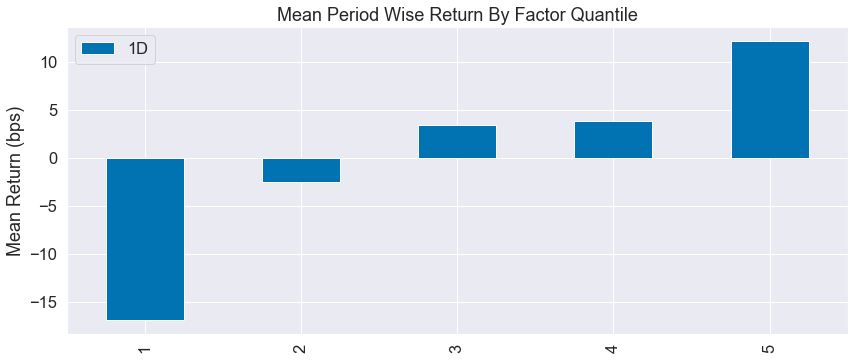

In [91]:
create_summary_tear_sheet(factor_data)

Returns Analysis


,1D
Ann. alpha,0.439
beta,0.139
Mean Period Wise Return Top Quantile (bps),12.212
Mean Period Wise Return Bottom Quantile (bps),-16.897
Mean Period Wise Spread (bps),29.109


<Figure size 432x288 with 0 Axes>

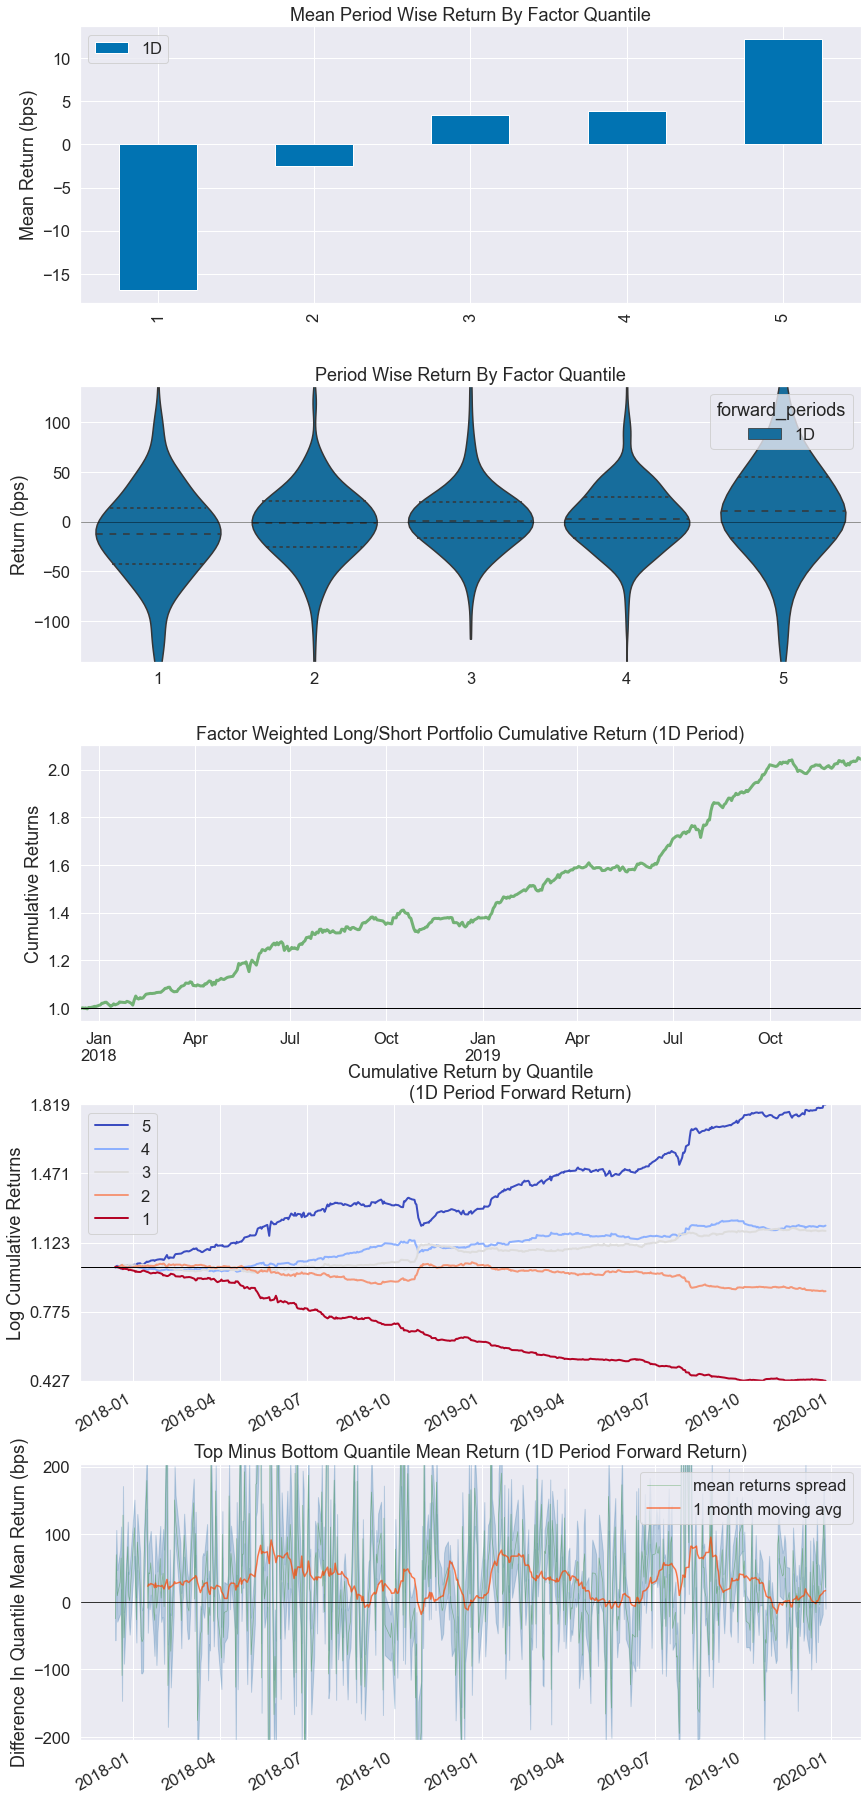

In [93]:
create_returns_tear_sheet(factor_data)